<a href="https://colab.research.google.com/github/stratoskar/thesis/blob/main/Python_Code/Notebook_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this section of the code, we use the same machine learning methodology, in order to train an XGBoost model on traffic flow data that have been produced **without the use of the SPQ algorithm**.

In [1]:
!pip install ipython-autotime

# measure execution time of each cell
%load_ext autotime

time: 348 µs (started: 2023-09-01 11:29:25 +00:00)


In [2]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# standard library imports
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

time: 529 ms (started: 2023-09-01 11:29:25 +00:00)


### Phase 7: Preprocess the time series dataset and add weather data on it
In this step, the following commands are executed:
- Load time series dataset that created **without** using SPQ function
- Preprocess the time series dataset
- Read weather data and preprocess them
- Aggregate traffic flow data with weather data
- Extract features that are helpful to our research

#### Step 1: Load the time series traffic flow dataset
In this step we are doing the following operations:
- Read the data
- Change the name of columns

In [3]:
# access google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.91 s (started: 2023-09-01 11:29:25 +00:00)


In [4]:
# define the path with the time series data made WITHOUT the use of SPQ data
PATH = '/content/drive/MyDrive/Colab Notebooks/San Francisco TF Pred/Preprocessing_Forecasting/Data/time_series_without_SPQ.txt'

time: 394 µs (started: 2023-09-01 11:29:27 +00:00)


In [5]:
# read a subset of the dataset
time_series = pd.read_csv(PATH,nrows=100)

time: 35.4 ms (started: 2023-09-01 11:29:27 +00:00)


In [6]:
# this list contains the column names
columns = ["Taxi ID","Traj ID","Path","Length"]

# generate the columns of the dataset
i =4
while(True):
    if i == 4:
        columns.append(pd.to_datetime('2008-05-18 00:00:00'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))

    if (columns[i]>=pd.to_datetime('2008-05-24 23:59:59.000130')):
        break

    i+=1

# delete the last timestamp
columns.pop()

# assign new column names to our dataframe
time_series.columns = columns

time: 37.1 ms (started: 2023-09-01 11:29:27 +00:00)


#### Step 2: Preprocess the time series dataset
In this step we are doing the following operations:
- Reshape it to long format using melt function
- Encode categorical values
- Preprocess the data types of each column

In [7]:
# reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = time_series.iloc[:,2:].columns
time_series = time_series.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
time_series['Time Column'] = pd.to_datetime(time_series['Time Column'])

# sort rows by Path and Time
time_series.sort_values(by=['Path','Time Column'],inplace=True)

time: 50.7 ms (started: 2023-09-01 11:29:27 +00:00)


In [8]:
# convert path column from categorical to numerical
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
label_encoder = LabelEncoder()

# fit label encoder on the 'Path' column
time_series['Path'] = label_encoder.fit_transform(time_series['Path'])

# sort the data based in Path column
time_series = time_series.sort_values(by=['Path','Time Column'])

# print data
time_series.head()

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
5,251,110,0,14,2008-05-18 00:00:00,14
105,251,110,0,14,2008-05-18 00:30:00,12
205,251,110,0,14,2008-05-18 01:00:00,13
305,251,110,0,14,2008-05-18 01:30:00,28
405,251,110,0,14,2008-05-18 02:00:00,22


time: 440 ms (started: 2023-09-01 11:29:27 +00:00)


#### Step 3: Read and preprocess the weather data
In this step we are doing the following operations:
- Read the weather data
- Drop uneccessary information
- Encode categorical attributes
- Fill Nan values

In [9]:
# define the path of weather data
path2 = '/content/drive/MyDrive/Colab Notebooks/San Francisco TF Pred/Preprocessing_Forecasting/Data/weather_data.csv'

# read weather data
weather_data = pd.read_csv(path2,sep=',')

# drop unecessary columns
# dropped columns can either have NaN values, or not be associated with traffic flow.
# columns kept: temperature, humidity, windspeed, sealevelpressure, visibility
weather_data = weather_data.drop(['name','feelslike','dew','precip','precipprob','preciptype',
                                  'snow','snowdepth','windgust','winddir','cloudcover',
                                  'solarradiation','solarenergy','uvindex','severerisk','stations','icon'],axis=1)

time: 15.5 ms (started: 2023-09-01 11:29:28 +00:00)


There is one column that contains categorical vales. Use one-hot encode it to represent it as numerical vector.

In [10]:
# view the values of "conditions" column
weather_data['conditions'].value_counts()

Partially cloudy    435
Clear               166
Overcast            142
Rain, Overcast        1
Name: conditions, dtype: int64

time: 4.1 ms (started: 2023-09-01 11:29:28 +00:00)


In [11]:
# change the only 'Rain, Overcast' value to 'Overcast'
weather_data.loc[weather_data['conditions'] == 'Rain, Overcast', 'conditions'] = 'Overcast'

time: 1.02 ms (started: 2023-09-01 11:29:28 +00:00)


In [12]:
# view again the values of "conditions" column
weather_data['conditions'].value_counts()

Partially cloudy    435
Clear               166
Overcast            143
Name: conditions, dtype: int64

time: 4.84 ms (started: 2023-09-01 11:29:28 +00:00)


In [13]:
# one-hot encode the  "conditions" column
conditions = pd.get_dummies(weather_data['conditions'], prefix='conditions')
weather_data.drop('conditions',axis=1,inplace=True)

# concatenate the one-hot encoded columns to the original DataFrame
weather_data = pd.concat([weather_data, conditions], axis=1)

time: 2.83 ms (started: 2023-09-01 11:29:28 +00:00)


In [14]:
# view for null values
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     744 non-null    object 
 1   temp                         744 non-null    float64
 2   humidity                     744 non-null    float64
 3   windspeed                    744 non-null    float64
 4   sealevelpressure             744 non-null    float64
 5   visibility                   744 non-null    float64
 6   conditions_Clear             744 non-null    uint8  
 7   conditions_Overcast          744 non-null    uint8  
 8   conditions_Partially cloudy  744 non-null    uint8  
dtypes: float64(5), object(1), uint8(3)
memory usage: 37.2+ KB
time: 10.3 ms (started: 2023-09-01 11:29:28 +00:00)


There are not null values in the weather dataset too!

In [15]:
# convert datetime column to appropriate format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# drop rows that are not in within the interval [2008-05-18,2008-05-24]
start_date = pd.to_datetime('2008-05-18')
end_date = pd.to_datetime('2008-05-25')
weather_data = weather_data[(weather_data['datetime'] >= start_date) & (weather_data['datetime'] <= end_date)].reset_index(drop=True)

time: 6.39 ms (started: 2023-09-01 11:29:28 +00:00)


#### Step 4: Connect the two dataframes to one
Use time information to correctly connect the weather data and traffic flow data together.

In [16]:
# connect two dataframes, time-series traffic flow and weather data
time_series.set_index('Time Column', inplace=True)
weather_data.set_index('datetime', inplace=True)

# resample the 'weather_data' dataset to 30-minute intervals and forward-fill the missing values
weather_data = weather_data.resample('30T').ffill()

# merge the time_series and weather_data_resampled datasets based on their indexes
time_series_weather = time_series.merge(weather_data, left_index=True, right_index=True)

time: 19.9 ms (started: 2023-09-01 11:29:28 +00:00)


In [17]:
# print dataset
time_series_weather

,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,humidity,windspeed,sealevelpressure,visibility,conditions_Clear,conditions_Overcast,conditions_Partially cloudy
2008-05-18 00:00:00,251,110,0,14,14,12.4,87.29,16.1,1017.7,16.0,0,0,1
2008-05-18 00:00:00,259,201,1,2,3,12.4,87.29,16.1,1017.7,16.0,0,0,1
2008-05-18 00:00:00,461,251,2,4,15,12.4,87.29,16.1,1017.7,16.0,0,0,1
2008-05-18 00:00:00,111,199,3,3,32,12.4,87.29,16.1,1017.7,16.0,0,0,1
2008-05-18 00:00:00,417,291,4,3,9,12.4,87.29,16.1,1017.7,16.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-05-24 23:30:00,43,725,95,4,0,12.4,72.31,10.5,1015.0,16.0,0,1,0
2008-05-24 23:30:00,505,538,96,3,72,12.4,72.31,10.5,1015.0,16.0,0,1,0
2008-05-24 23:30:00,122,166,97,4,15,12.4,72.31,10.5,1015.0,16.0,0,1,0
2008-05-24 23:30:00,53,541,98,2,56,12.4,72.31,10.5,1015.0,16.0,0,1,0


time: 21.2 ms (started: 2023-09-01 11:29:28 +00:00)


#### Step 5: Feature Creation From Time Information
In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [18]:
time_series_weather = time_series_weather.reset_index()
time_series_weather.rename(columns={'index': 'Time Column'}, inplace=True)

time: 6.03 ms (started: 2023-09-01 11:29:28 +00:00)


In [19]:
### extract timestamp information to different columns ###

time_series_weather['hour'] = time_series_weather['Time Column'].dt.hour
time_series_weather['dayofweek'] = time_series_weather['Time Column'].dt.dayofweek
time_series_weather['day'] = time_series_weather['Time Column'].dt.day
time_series_weather['minute'] = time_series_weather['Time Column'].dt.minute

### circular Encoding for cyclic time features ###

time_series_weather['hour_sin'] = np.sin(2 * np.pi * time_series_weather['hour'] / 24)
time_series_weather['hour_cos'] = np.cos(2 * np.pi * time_series_weather['hour'] / 24)

time_series_weather['day_of_week_sin'] = np.sin(2 * np.pi * time_series_weather['dayofweek'] / 7)
time_series_weather['day_of_week_cos'] = np.cos(2 * np.pi * time_series_weather['dayofweek'] / 7)

time_series_weather['day_sin'] = np.sin(2 * np.pi * time_series_weather['day'] / 31)
time_series_weather['day_cos'] = np.cos(2 * np.pi * time_series_weather['day'] / 31)

time_series_weather['minute_sin'] = np.sin(2 * np.pi * time_series_weather['minute'] / 60)
time_series_weather['minute_cos'] = np.cos(2 * np.pi * time_series_weather['minute'] / 60)

time: 44.2 ms (started: 2023-09-01 11:29:28 +00:00)


In [20]:
# define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

time: 910 µs (started: 2023-09-01 11:29:28 +00:00)


In [21]:
# apply the custom function on the data to create the '3hour_interval' column
time_series_weather['3hour_interval'] = time_series_weather['hour'].apply(get_3hour_interval)

time: 32.2 ms (started: 2023-09-01 11:29:28 +00:00)


In [22]:
# print dataset
time_series_weather

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,humidity,windspeed,sealevelpressure,...,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,2008-05-18 00:00:00,251,110,0,14,14,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
1,2008-05-18 00:00:00,259,201,1,2,3,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
2,2008-05-18 00:00:00,461,251,2,4,15,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
3,2008-05-18 00:00:00,111,199,3,3,32,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
4,2008-05-18 00:00:00,417,291,4,3,9,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33595,2008-05-24 23:30:00,43,725,95,4,0,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
33596,2008-05-24 23:30:00,505,538,96,3,72,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
33597,2008-05-24 23:30:00,122,166,97,4,15,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
33598,2008-05-24 23:30:00,53,541,98,2,56,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8


time: 60.5 ms (started: 2023-09-01 11:29:28 +00:00)


#### Step 6: Find highly correlated data in the dataset

In [23]:
import seaborn as sns

time: 102 ms (started: 2023-09-01 11:29:28 +00:00)


<Axes: >

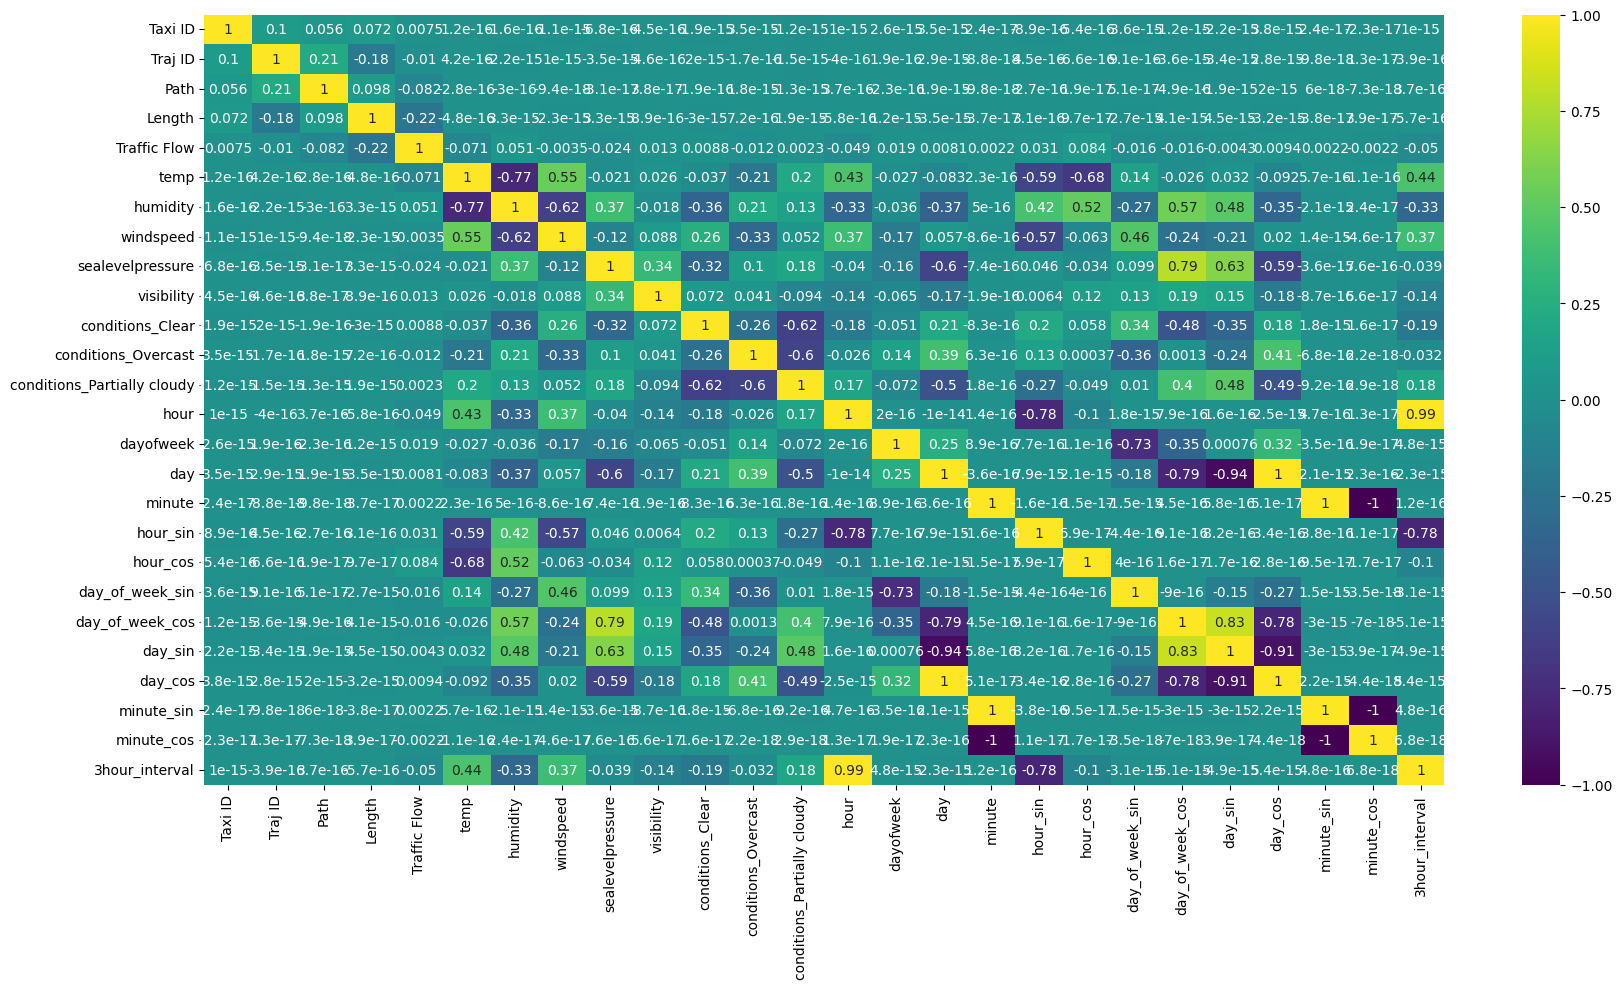

time: 2.52 s (started: 2023-09-01 11:29:28 +00:00)


In [24]:
# print correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(time_series_weather.corr(), annot=True, cmap='viridis')

### Phase 8: Build an XGBoost model for traffic flow forecasting
In this step, the following commands are executed:
- Train and Test split
- Find the best lookback timesteps for our XGBoost model
- Perform Grid Search CV to find the optimum parameters for the XGBoost model
- Train XGboost model
- Visualise the losses of the model
- Test on testing set of the model
- Add in the same dataframe the RMSE and MAE scores of the model
- Make visualizations on actual vs predicted traffic flow data

#### Step 1: Train - Test split
In this step, we split the data into two datasets, train and test.
The time inteval of all observations in this dataset are within [18-05-2008, 24-05-2008].
- Train dataset contains all the data for each path till 2008-05-23 inclusive.
- The rest of the data (the most resent ones) are in the test dataset

In [25]:
# sort the time series data
time_series_weather.sort_values(by=['Path','Time Column'], inplace=True)

time: 33.2 ms (started: 2023-09-01 11:29:31 +00:00)


In [26]:
# define train data
train = time_series_weather.loc[time_series_weather['Time Column'] < '2008-05-24']

# define test data
test = time_series_weather.loc[time_series_weather['Time Column'] >= '2008-05-24']

# print the results
print("Train set shape: ",train.shape)
print("Test set shape: ",test.shape)

Train set shape:  (28800, 27)
Test set shape:  (4800, 27)
time: 26.5 ms (started: 2023-09-01 11:29:31 +00:00)


In [27]:
# redefine train and test sets based on correlated features (drop highly correlated features)
train = train.drop(['Time Column','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1)
test = test.drop(['Time Column','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1)

time: 11.5 ms (started: 2023-09-01 11:29:31 +00:00)


#### Step 2: Find the best lookback timesteps for our XGBoost model
In this step, we define the optimum lookback timestep number for our sliding window. This optimum number will be used by the model for forecasting.

##### Step 2a: Create empty dataframe to store the scores per lookback timesteps

In [28]:
# find best lookback timesteps to perform analysis. Save those scores in a separate dataframe
lookback_scores = pd.DataFrame(columns=['#Timesteps','XGBoost Score'])
lookback_scores['#Timesteps'] = 0
lookback_scores['XGBoost Score'] = 0

time: 4.98 ms (started: 2023-09-01 11:29:31 +00:00)


##### Step 2b: Create function that converts the data into a supervised problem
Consider for each path n_in timesteps of traffic flow in the past, in order to predict the n_out traffic flow timesteps in the future.

In [29]:
from pandas import DataFrame
from pandas import concat

# create functio for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Traffic Flow %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Traffic Flow %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Traffic Flow %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    return agg

time: 1.23 ms (started: 2023-09-01 11:29:31 +00:00)


In [30]:
"""
Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
Then, concatenate the rest of the culumns.
"""
def generate_X_y_pairs(data,n_in=1,n_out=1):
    new_data = pd.DataFrame()
    for item in data['Path'].unique():

        # call function only for traffic flow columns
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # the rest of the columns are concatenated as they were
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, time_series_weather[time_series_weather['Path'] == item]], axis=1)

        new_data = pd.concat([new_data,supervised_traffic_flow])

    new_data.dropna(inplace=True)
    return new_data

time: 722 µs (started: 2023-09-01 11:29:31 +00:00)


##### Step 2c: Create a loop. In each loop, we are doing the following:
- 0. Convert train and test sets into supervised problem with lookback timesteps.
- 1. Define features and labels.
- 2. Train the XGboost model with defult parameters
- 3. Predict on the test set
- 4. Save RMSE in a dataframe

In [31]:
# import libraries
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

time: 70.3 ms (started: 2023-09-01 11:29:31 +00:00)


In [32]:
for lookback in [2,3,4,5,6]: # different lookback sizes

    # convert train and test data to supervised
    train_s = generate_X_y_pairs(train,lookback)
    test_s = generate_X_y_pairs(test,lookback)

    print("Lookback = "+str(lookback)+" - To supervised: Completed!")

    # add rolling mean information
    train_s['rolling_mean'] = 0
    test_s['rolling_mean'] = 0

    train_s['rolling_mean'] = train_s.iloc[:,0:lookback].mean(axis=1)
    test_s['rolling_mean'] = test_s.iloc[:,0:lookback].mean(axis=1)

    # define features
    features_s = train_s.drop(['Time Column','Traffic Flow','Traffic Flow 1(t)'],axis=1).columns

    # define label
    labels_s = ['Traffic Flow 1(t)']

    # create X_train and y_train datasets
    X_train_s = train_s[features_s]
    y_train_s = train_s[labels_s]

    # create X_test and y_test datasets
    X_test_s = test_s[features_s]
    y_test_s = test_s[labels_s]

    print("Lookback = "+str(lookback)+" - Train and Test sets: Completed!")

    # define XGBoost regression model
    reg = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000,early_stopping_rounds = 5)

    # train the XGBoost model with feature weights (use validation set on test data)
    reg.fit(X_train_s, y_train_s, eval_set=[(X_train_s, y_train_s), (X_test_s,y_test_s)],verbose=False)

    print("Lookback = "+str(lookback)+" - Trainning: Completed!")

    # make predictions
    y_pred_s = reg.predict(X_test_s)

    # calculate RMSE score
    rmse = mean_squared_error(y_test_s, y_pred_s, squared=False)

    # create a new row as a dictionary
    new_row = {'#Timesteps': lookback, 'XGBoost Score': rmse}

    # append the new row to the DataFrame
    lookback_scores = lookback_scores.append(new_row, ignore_index=True)

    print("Lookback = "+str(lookback)+" - Saved Results: Completed!")

Lookback = 2 - To supervised: Completed!
Lookback = 2 - Train and Test sets: Completed!
Lookback = 2 - Trainning: Completed!
Lookback = 2 - Saved Results: Completed!
Lookback = 3 - To supervised: Completed!
Lookback = 3 - Train and Test sets: Completed!
Lookback = 3 - Trainning: Completed!
Lookback = 3 - Saved Results: Completed!
Lookback = 4 - To supervised: Completed!
Lookback = 4 - Train and Test sets: Completed!
Lookback = 4 - Trainning: Completed!
Lookback = 4 - Saved Results: Completed!
Lookback = 5 - To supervised: Completed!
Lookback = 5 - Train and Test sets: Completed!
Lookback = 5 - Trainning: Completed!
Lookback = 5 - Saved Results: Completed!
Lookback = 6 - To supervised: Completed!
Lookback = 6 - Train and Test sets: Completed!
Lookback = 6 - Trainning: Completed!
Lookback = 6 - Saved Results: Completed!
time: 27.7 s (started: 2023-09-01 11:29:31 +00:00)


#####  Step 2d: Print RMSE scores over lookback timesteps into a graph

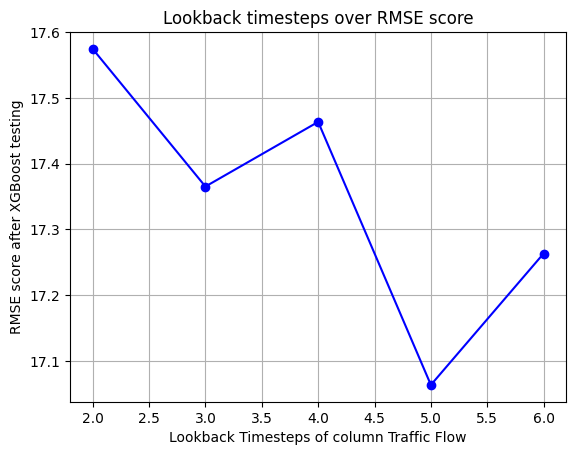

time: 202 ms (started: 2023-09-01 11:29:59 +00:00)


In [33]:
# plot the data
plt.plot(lookback_scores['#Timesteps'], lookback_scores['XGBoost Score'], linestyle='-', marker='o', color='b')

# set plot title and axis labels
plt.title('Lookback timesteps over RMSE score')
plt.xlabel('Lookback Timesteps of column Traffic Flow')
plt.ylabel('RMSE score after XGBoost testing')

# add gridlines
plt.grid(True)

# show the plot
plt.show()

In [34]:
# find the timesteps corresponding to the minimum RMSE score
optimum_lookback = int(lookback_scores['#Timesteps'].loc[lookback_scores['XGBoost Score'].idxmin()])

time: 778 µs (started: 2023-09-01 11:29:59 +00:00)


#### Step 3: Perform Grid Search CV to find the optimum parameters for the XGBoost model
This step is essential to tune correctly the XGboost model.

##### Step 3a: Split train and test into supervised problem, based on optimum lookback timesteps that found above.

In [35]:
# convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train,optimum_lookback)
test = generate_X_y_pairs(test,optimum_lookback)

time: 994 ms (started: 2023-09-01 11:29:59 +00:00)


##### Step 3b: Extract features about trend of time series
In this step we define the rolling mean and rolling variance of a window. Since we are trying to forecast the last value of each window, only the first optimum_lookback values in the window are used to compute rolling features. The last value (that we are trying to forecast) is not included.

In [36]:
# add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

train['rolling_var'] = 0
test['rolling_var'] = 0

# calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:optimum_lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

time: 15.1 ms (started: 2023-09-01 11:30:00 +00:00)


#####  Step 3c: Define labels and features
- Features will help the XGBoost algorithm to predict the output value, the label. We will use all the traffic flow information at previous timesteps (t-n,t-n+1...,t-2,t-1), as well as the rest of the features (time and trend information) as features.
- Label will be out target value, the Traffic Flow at timestep t.

In [37]:
# define features
features = train.drop(['Time Column','Traffic Flow 1(t)','Traffic Flow','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1).columns

# define labels
labels = ['Traffic Flow 1(t)']

# create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

time: 10.5 ms (started: 2023-09-01 11:30:00 +00:00)


In [38]:
# show shape information about X and y training and testing sets
print("Shape of X_train is: ",X_train.shape)
print("Shape of y_train is: ",y_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is:  (28300, 26)
Shape of y_train is:  (28300, 1)
Shape of X_test is:  (4300, 26)
Shape of y_test is:  (4300, 1)
time: 6.64 ms (started: 2023-09-01 11:30:00 +00:00)


##### Step 3d: Apply GridSearchCV
Use a 5-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [39]:
from sklearn.model_selection import GridSearchCV

time: 337 µs (started: 2023-09-01 11:30:00 +00:00)


In [40]:
# tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [500,1000,1500],
    "learning_rate": [0.1],
    "max_depth": [3,9],
    "objective":['reg:squarederror'],
    "gamma": [0,1,2],
    "alpha": [0,0.1,1]
}

# define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        verbose=1,
                        scoring= "neg_mean_squared_error")

# train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
[6]	validation_0-rmse:28.12666	validation_1-rmse:26.07913
[7]	validation_0-rmse:26.49246	validation_1-rmse:24.57249
[8]	validation_0-rmse:25.05247	validation_1-rmse:23.30546
[9]	validation_0-rmse:23.76669	validation_1-rmse:22.18644
[10]	validation_0-rmse:22.72512	validation_1-rmse:21.27281
[11]	validation_0-rmse:21.84215	validation_1-rmse:20.52054
[12]	validation_0-rmse:21.08843	validation_1-rmse:19.85090
[13]	validation_0-rmse:20.45277	validation_1-rmse:19.32027
[14]	validation_0-rmse:19.88087	validation_1-rmse:18.89542
[15]	validation_0-rmse:19.42445	validation_1-rmse:18.51872
[16]	validation_0-rmse:19.03554	validation_1-rmse:18.22364
[17]	validation_0-rmse:18.70404	validation_1-rmse:17.99016
[18]	validation_0-rmse:18.43407	validation_1-rmse:17.79908
[19]	validation_0-rmse:18.19877	validation_1-rmse:17.63627
[20]	validation_0-rmse:17.99246	validation_1-rmse:17.51175
[21]	validation_0-rmse:17.80144	validation_1-rmse:17.39430
[22]	

#### Step 4: Train an XGboost model
We will fit all the data in this model using the optimum parameters we found above.

Create XGBoost model and train it

In [41]:
# define XGBoost regressor
reg = xgb.XGBRegressor(
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = xgb_grid.best_params_['n_estimators'],
    alpha = xgb_grid.best_params_['alpha'],
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective']
)

# train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=True)

[0]	validation_0-rmse:44.12934	validation_1-rmse:41.24587
[1]	validation_0-rmse:40.60524	validation_1-rmse:37.90628
[2]	validation_0-rmse:37.46863	validation_1-rmse:34.89757
[3]	validation_0-rmse:34.70784	validation_1-rmse:32.33933
[4]	validation_0-rmse:32.27391	validation_1-rmse:30.08249
[5]	validation_0-rmse:30.13651	validation_1-rmse:28.14729
[6]	validation_0-rmse:28.26526	validation_1-rmse:26.45064
[7]	validation_0-rmse:26.63624	validation_1-rmse:24.94777
[8]	validation_0-rmse:25.22900	validation_1-rmse:23.63990
[9]	validation_0-rmse:24.01324	validation_1-rmse:22.53591
[10]	validation_0-rmse:22.96689	validation_1-rmse:21.58993
[11]	validation_0-rmse:22.07779	validation_1-rmse:20.82708
[12]	validation_0-rmse:21.31350	validation_1-rmse:20.19759
[13]	validation_0-rmse:20.66302	validation_1-rmse:19.65293
[14]	validation_0-rmse:20.10451	validation_1-rmse:19.18887
[15]	validation_0-rmse:19.62816	validation_1-rmse:18.84015
[16]	validation_0-rmse:19.21588	validation_1-rmse:18.49904
[17]	va

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

time: 11.8 s (started: 2023-09-01 11:35:01 +00:00)


Feature Importance of XGBoost model
Show how our model used the feautres, in order to perform splits.

<Figure size 1500x500 with 0 Axes>

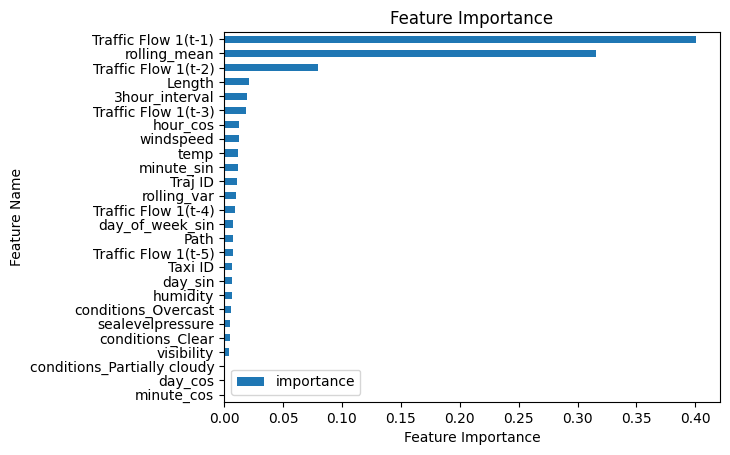

time: 352 ms (started: 2023-09-01 11:35:13 +00:00)


In [42]:
# show how much each of the features was used in our regression analysis
plt.figure(figsize=(15,5))
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

Plot train and validation errors of XGBoost model in the same graph

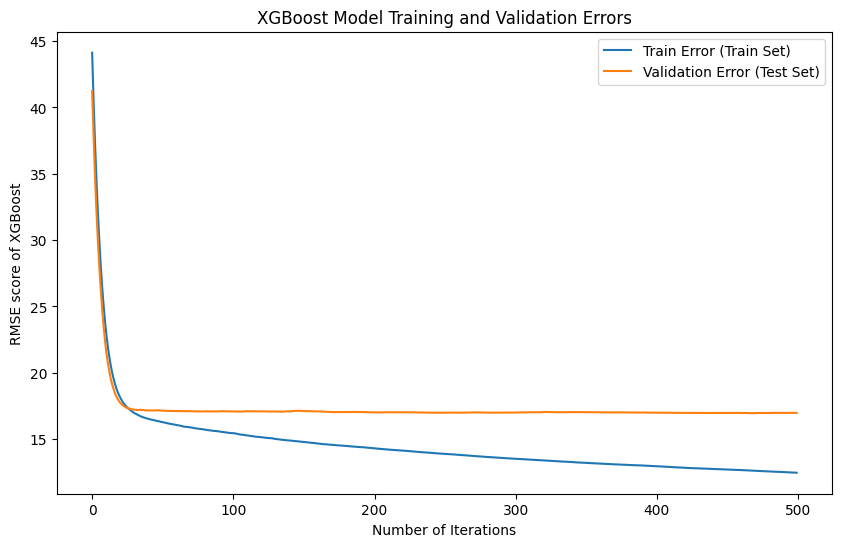

time: 245 ms (started: 2023-09-01 11:35:14 +00:00)


In [43]:
# acquire the values of train and validation errors
results = reg.evals_result()
train_errors = results['validation_0']['rmse']
validation_errors = results['validation_1']['rmse']

# plot the validation and training errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train Error (Train Set)')
plt.plot(validation_errors, label='Validation Error (Test Set)')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE score of XGBoost')
plt.title('XGBoost Model Training and Validation Errors')
plt.legend()
plt.show()

Make predictions on the test set

In [44]:
y_pred_xgboost = reg.predict(X_test)

time: 22.5 ms (started: 2023-09-01 11:35:14 +00:00)


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  8.408839858947431
RMSE score: 16.972748290300622
time: 8 ms (started: 2023-09-01 11:35:14 +00:00)


Show example of how well the model learned the trainning data.

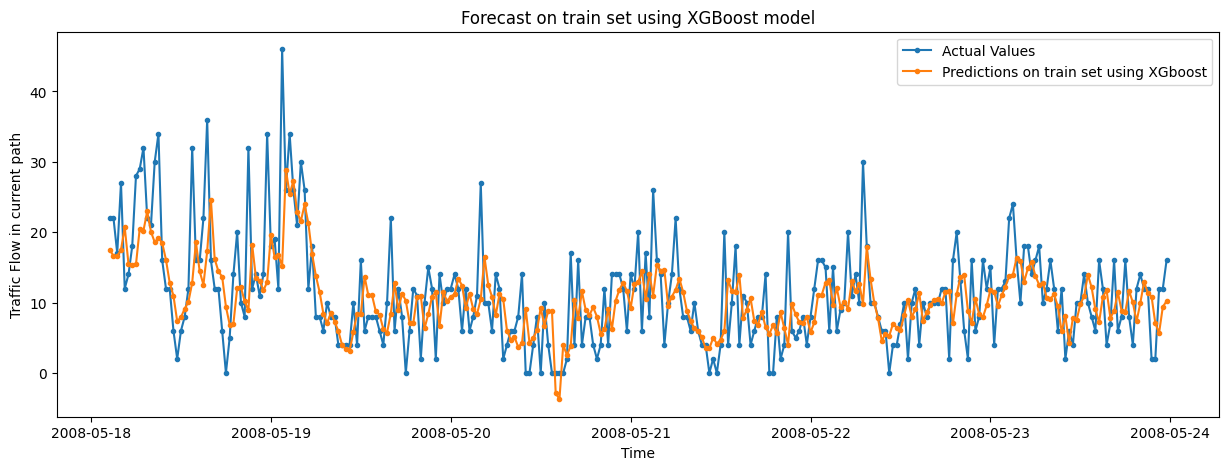

time: 375 ms (started: 2023-09-01 11:35:14 +00:00)


In [46]:
# predict on the trainning set
y_pred_train = reg.predict(X_train)

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Traffic Flow 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train)
train_predictions.insert(2,'Path',X_train['Path'].values)

# plot an example of the train-predictions at path 0 of the datase
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0]['Train Actual'],".-",label='Actual Values')
plt.plot(train_predictions[train_predictions['Path']==0]['Train Predicted'],".-",label='Predictions on train set using XGboost')
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.title('Forecast on train set using XGBoost model')
plt.legend()
plt.show()

Show an example of actual values vs predicted on test set

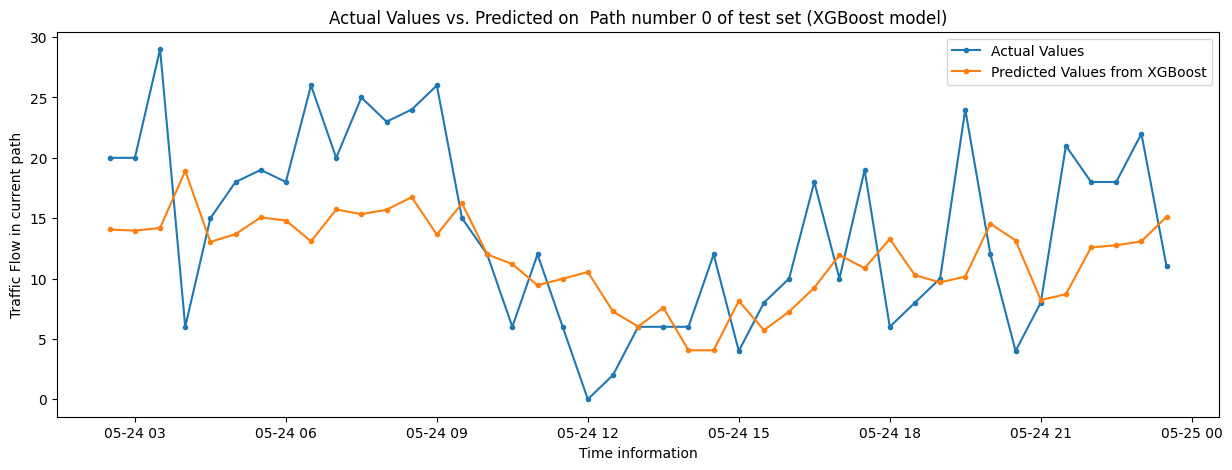

time: 286 ms (started: 2023-09-01 11:35:14 +00:00)


In [47]:
test_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
test_predictions.insert(0,'Test Actual',y_test['Traffic Flow 1(t)'].values)
test_predictions.insert(1,'Test Predicted',y_pred_xgboost)
test_predictions.insert(2,'Path',X_test['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(test_predictions[test_predictions['Path']==0]['Test Actual'],".-",label='Actual Values')
plt.plot(test_predictions[test_predictions['Path']==0]['Test Predicted'],".-",label='Predicted Values from XGBoost')
plt.xlabel('Time information')
plt.ylabel('Traffic Flow in current path')
plt.title('Actual Values vs. Predicted on  Path number 0 of test set (XGBoost model)')
plt.legend()
plt.show()

#### Step 5: Add in the same dataframe the RMSE and MAE scores and print it

In [48]:
# create dataframe with scores
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# define row for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}

# add row to dataframe
scores = scores.append(new_row, ignore_index=True)

time: 7.43 ms (started: 2023-09-01 11:35:15 +00:00)


In [49]:
# print dataframe with model's score
scores

,Model,RMSE Score,MAE Score
0,XGBoost,16.972748,8.40884


time: 6.78 ms (started: 2023-09-01 11:35:15 +00:00)
